# Imports

In [1]:
import math
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch.utils.data import DataLoader

from datasets import ModelnetDataset, ShapenetDataset, JointDataset
from transforms import SetRotation
from vae import BPCVAE
from modelutils import cd

# Prepare dataset

In [2]:
modelnet_train = ModelnetDataset(filter=1)
modelnet_test = ModelnetDataset(filter=1, test=True)
modelnet_train_loader = DataLoader(modelnet_train, batch_size=32, shuffle=True, num_workers=2)
modelnet_test_loader = DataLoader(modelnet_test, batch_size=32, shuffle=True, num_workers=2)

shapenet_train = ShapenetDataset(filter=1, transform=SetRotation((0, math.acos(0), 0)))
shapenet_test = ShapenetDataset(filter=1, test=True, transform=SetRotation((0, math.acos(0), 0)))
shapenet_train_loader = DataLoader(shapenet_train, batch_size=32, shuffle=True, num_workers=2)
shapenet_test_loader = DataLoader(shapenet_test, batch_size=32, shuffle=True, num_workers=2)

joint_train = JointDataset(filter=1, transform_shapenet=SetRotation((0, math.acos(0), 0)))
joint_test = JointDataset(filter=1, test=True, transform_shapenet=SetRotation((0, math.acos(0), 0)))
joint_train_loader = DataLoader(joint_train, batch_size=32, shuffle=True, num_workers=2)
joint_test_loader = DataLoader(joint_test, batch_size=32, shuffle=True, num_workers=2)

print(len(joint_train))

3943


# Load model

In [3]:
model = BPCVAE.load_from_drive(BPCVAE, name='beta_pcvae', decoder=[1024,1024,1024,2048], encoder=[1024])

# Visualize some reconstructions

In [4]:
def zzip(a, b):
    if len(a) == 0:
        return b
    if len(b) == 0:
        return a
    return [a[0], b[0]] + zzip(a[1:], b[1:])

def unstack(t):
    return [x.squeeze(0) for x in list(t.split(1))]

In [5]:
def subplot_num(m, i, j):
    return i*m + j

def draw_pc(ax, pc):
    pc = SetRotation((np.pi/2, -np.pi, 0))(pc)
    X, Y, Z = np.split(pc, 3)
    ax.scatter(X, Y, Z)

def plot_samples(samples, n, m, save=False, savename='pclouds'):
    fig = plt.figure(figsize=(4.5*m,4.5*n))
    fig.set_tight_layout(True)
    for i in range(n):
        for j in range(m):
            idx = subplot_num(m, i, j)
            ax = fig.add_subplot(n, m, idx+1, projection='3d', xticks=[], yticks=[], zticks=[])
            draw_pc(ax, samples[idx])    
    if save:
        plt.savefig(savename, bbox_inches='tight', pad_inches=0)
    plt.show()

In [94]:
batch, _ = next(iter(joint_train_loader))
rec, _ = model(batch, binarize=True)
batch_rec = zzip(unstack(batch), unstack(rec.detach()))
dist = cd(batch, rec)
list(enumerate(list(dist)))

[(0, tensor(0.5638, grad_fn=<SelectBackward>)),
 (1, tensor(0.8252, grad_fn=<SelectBackward>)),
 (2, tensor(1.5890, grad_fn=<SelectBackward>)),
 (3, tensor(1.5174, grad_fn=<SelectBackward>))]

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


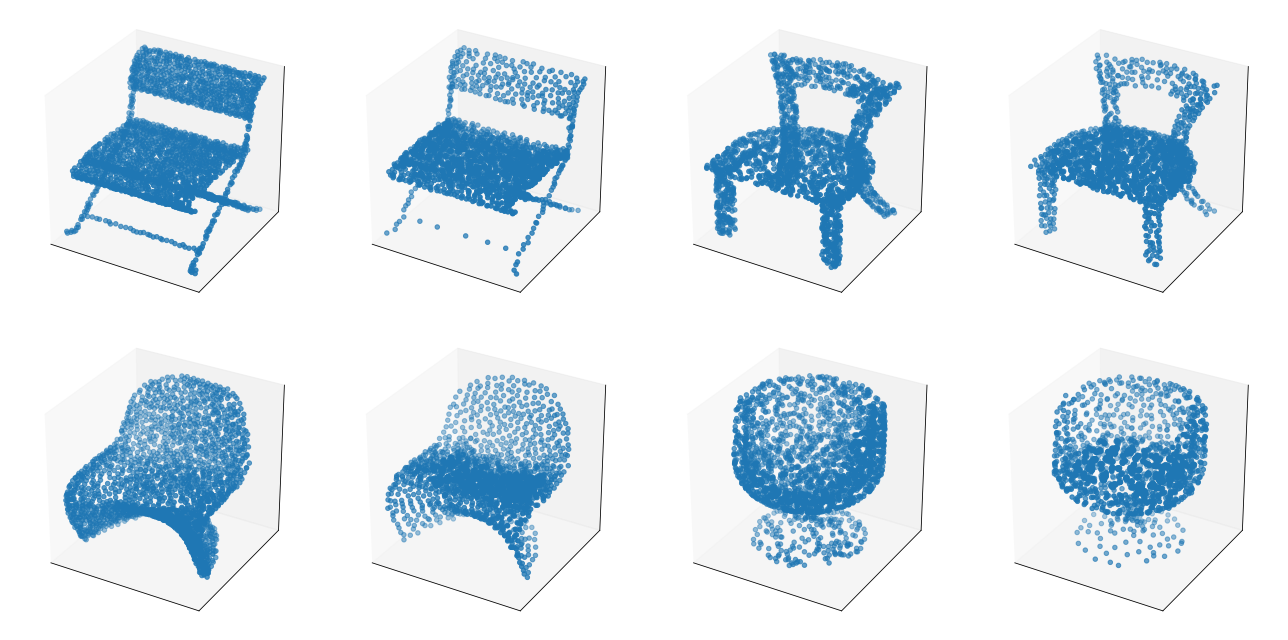

In [96]:
plot_samples(batch_rec, 4, 4)

# Interpolation

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


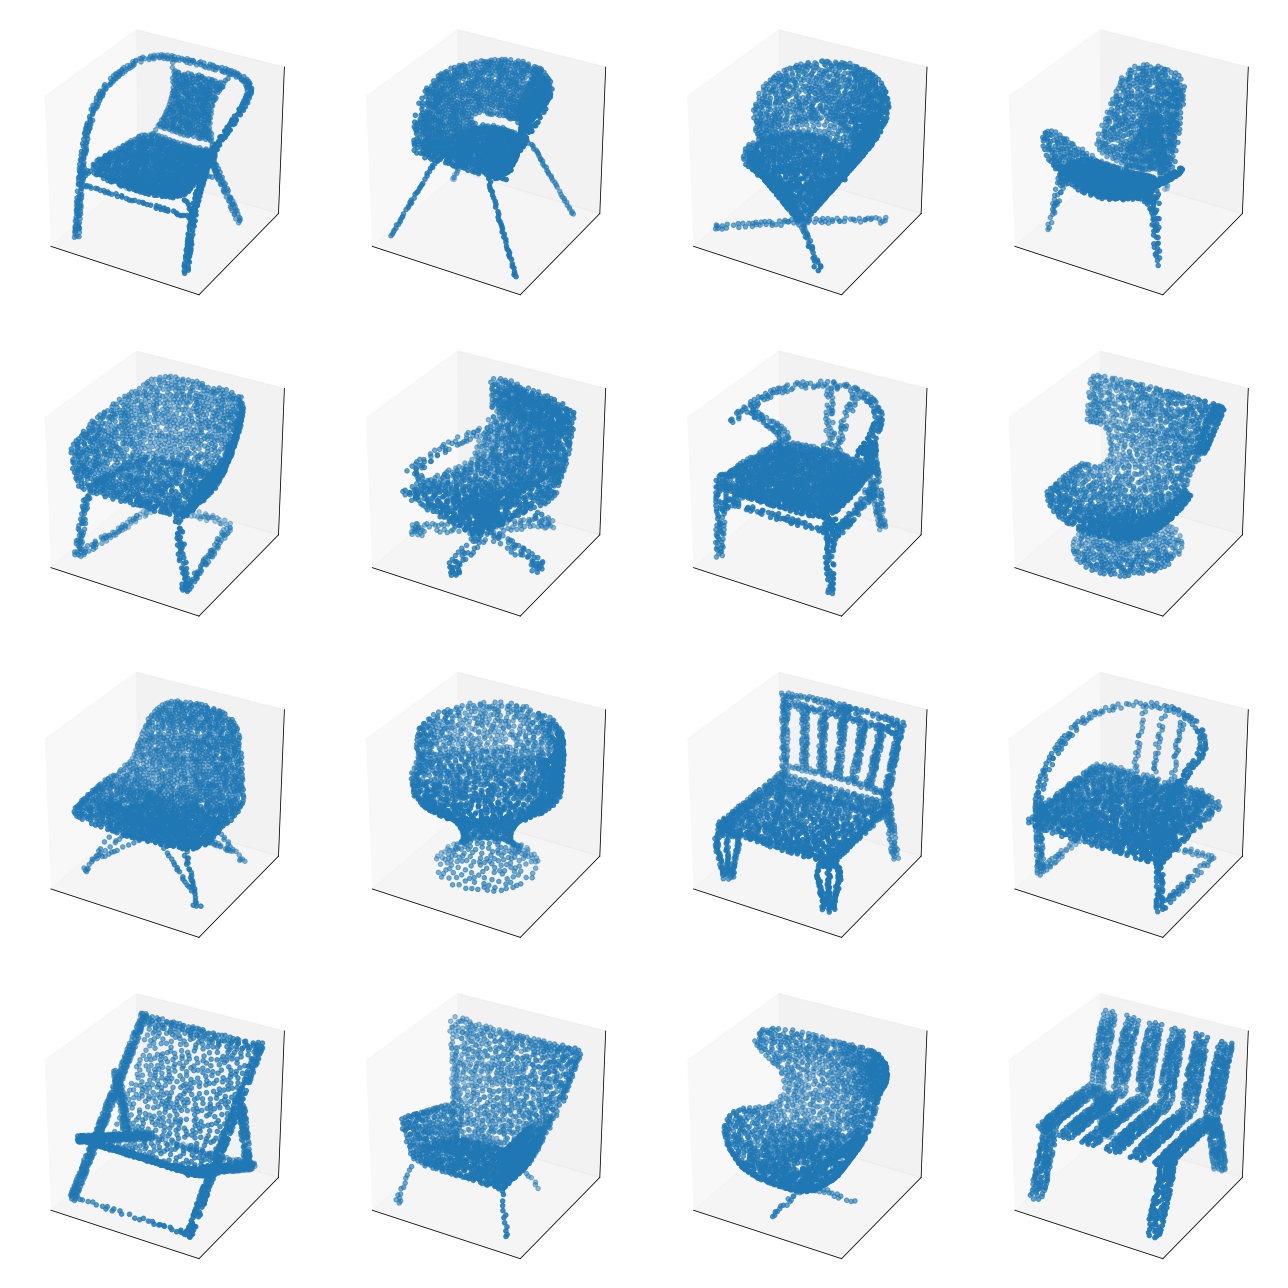

In [186]:
fancy_objects = torch.tensor(np.load('fancy_objects.npy'))
plot_samples(fancy_objects, 4, 4)

In [198]:
num_steps = 6

sources = [10, 8]
targets = [13, 0]

all_steps = []

for idx in range(len(sources)):
    source = fancy_objects[sources[idx]]
    target = fancy_objects[targets[idx]]
    (source_latent, target_latent), _, _ = model.encode(torch.stack([source, target], dim=0))
    diff = target_latent - source_latent
    nzero = torch.nonzero(diff).squeeze(1)
    idxs = nzero[torch.randperm(nzero.shape[0])]
    steps = [source_latent]
    for x in torch.linspace(0.45,0.8,steps=num_steps-2):
        to = int(x*idxs.shape[0])
        step = source_latent.clone()
        step[idxs[:to]] += diff[idxs[:to]]
        steps.append(step)
    steps.append(target_latent)
    latent_steps = torch.stack(steps, dim=0)
    interpolation_steps = model.decoder(latent_steps).reshape((-1,)+source.shape).detach()
    all_steps.append(interpolation_steps)
    
all_steps = torch.cat(all_steps, dim=0)

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


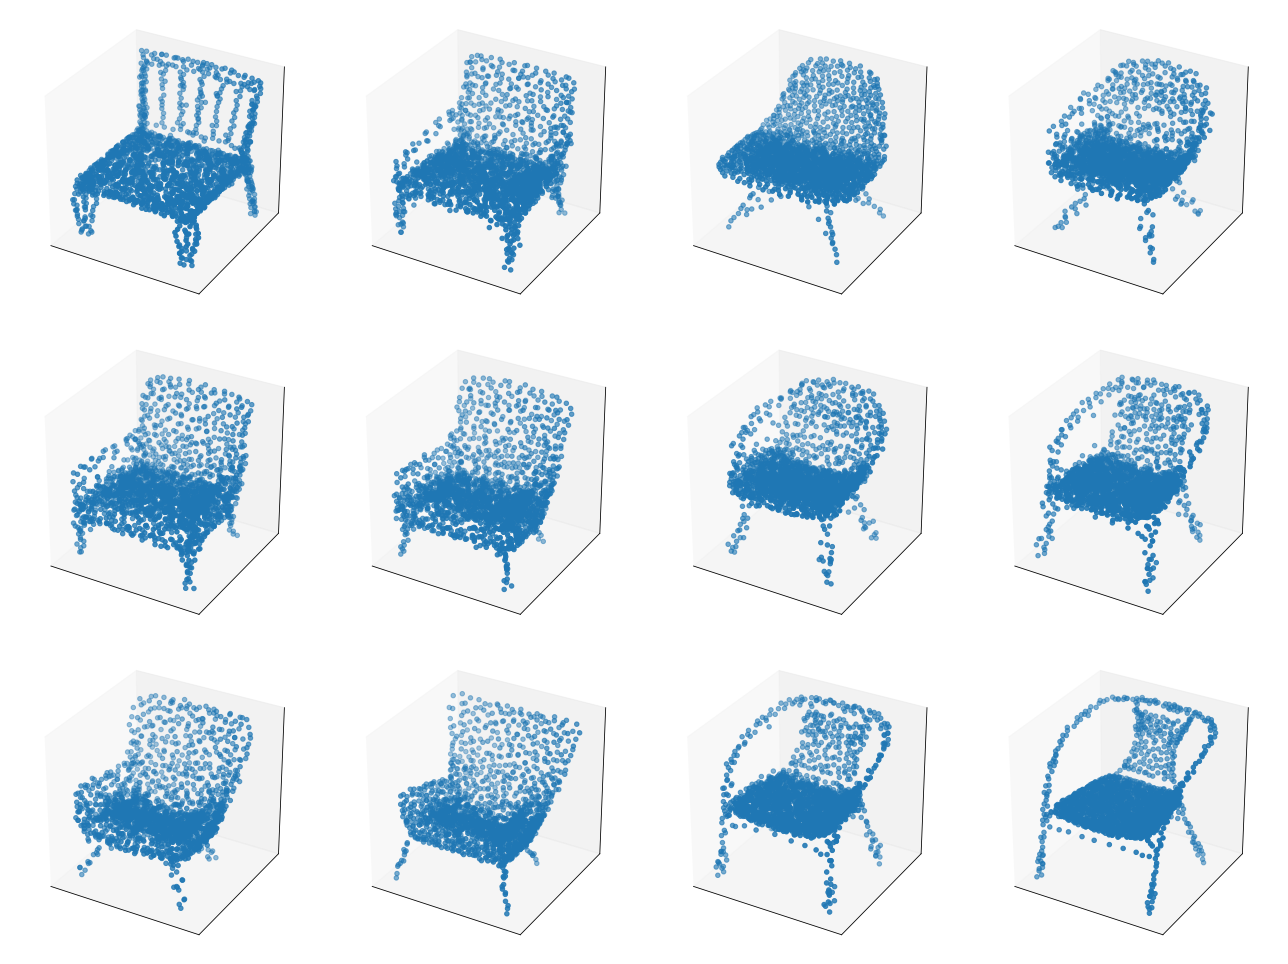

In [214]:
plot_samples(saved, 3, 4)

# Latent arithmetic

In [162]:
samples = torch.tensor(np.load('nice_arithmetic.npy'))

In [ ]:
latents = model.encode_sample_binarize(samples)
all_samples = []
for i in range(0, len(samples), 3):
    a, b, c = samples[i:i+3]
    al, bl, cl = latents[i:i+3]
    dl = torch.clamp(al-bl+cl, min=0, max=1)
    d = model.decode_at_mean(dl.unsqueeze(0)).detach().reshape((-1,)+samples[0].shape)[0]
    all_samples += [a, b, c, d]
joint = torch.stack(all_samples, dim=0)

In [ ]:
plot_samples(joint, 2, 4)

# Losowanie latentu

In [169]:
num_samples = 48

sample_shape = batch[0].shape
rec, _, _ = model.encode(batch)
latent = rec.shape[1]
# z = 1.0*torch.randn(num_samples, latent)
z = torch.bernoulli(torch.full((num_samples, latent), 0.5))

In [183]:
rec = model.decoder(z).reshape((num_samples,)+sample_shape).detach()

/Users/kubaz/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


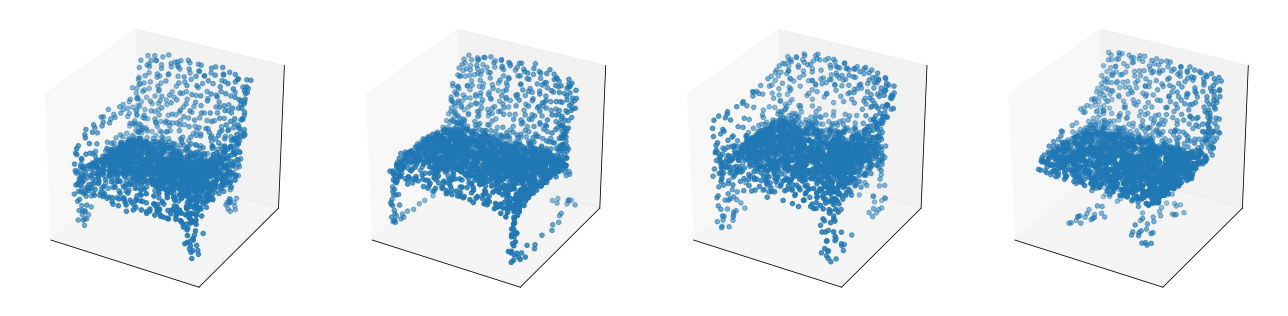

In [185]:
plot_samples(rec, 4, 4)

# Histogram z

In [ ]:
with torch.no_grad():
    latents_list = [model.encode_sample(x) for x, _ in joint_loader]
latents = torch.cat(latents_list, dim=0).flatten().detach().numpy()

In [ ]:
vals, bins = np.histogram(latents, bins=np.linspace(0, 1, 101))
vals = vals.astype(np.float) / latents.shape[0]

In [ ]:
plt.bar(bins[:-1], vals, width=0.01, align='edge', label='histogram z')
plt.plot(bins, beta.pdf(bins, 0.01, 0.01), color='orange', label='Beta(0.01, 0.01)')
plt.legend()
plt.show()

# Loss on loader

In [11]:
def loss_on_loader(model, loader, binarize=False):
    total = 0
    batches = 0
    with torch.no_grad():
        for x, _ in loader:
            batches += 1
            if binarize:
                rec, _ = model.forward_binarized(x)
            else:
                rec, _ = model(x)
            total += torch.mean(cd(x, rec))
    return total / batches

In [12]:
loss_on_loader(model, train_loader)

tensor(1.0247)

In [13]:
loss_on_loader(model, train_loader, binarize=True)

tensor(1.0271)

In [15]:
loss_on_loader(model, test_loader)

tensor(1.4644)

In [16]:
loss_on_loader(model, test_loader, binarize=True)

tensor(1.4648)

# Coverage

In [ ]:
recs_list = []
with torch.no_grad():
    for x, _ in test_loader:
        rec, _ = model(batch)
        recs_list.append(rec)
recs = torch.cat(recs_list, dim=0)

In [ ]:
def nearest(sample, loader):
    best = float('inf')
    sample = sample.unsqueeze(0)
    with torch.no_grad():
        for x, _ in loader:
            y = sample.expand(x.shape[0], -1, -1)
            d = cd(x, y)
            d[d < 1e-4] += float('inf')
            best = min(best, torch.min(d).item())
    print(best)
    return best

def nearest_for_each(source_loader, target_loader):
    nearest_list = []
    with torch.no_grad():
        for x, _ in source_loader:
            nearest_list += [nearest(x[idx], target_loader) for idx in range(x.shape[0])]
    return torch.cat(nearest_list, dim=0)

In [ ]:
recs_dataset = FromNpDataset(recs, np.zeros(recs.shape[0]))
recs_loader = DataLoader(recs_dataset, batch_size=32, shuffle=False, num_workers=2)

orig_to_orig = nearest_for_each(test_loader, test_loader)
orig_to_rec = nearest_for_each(test_loader, recs_loader)

float(torch.sum(orig_to_rec < orig_to_orig) / recs.shape[0])